<a href="https://colab.research.google.com/github/ridwibra/text-summarization/blob/main/text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf

In [2]:
#load the data
summary = pd.read_csv('/content/news_summary.csv', encoding='iso-8859-1')
raw = pd.read_csv('/content/news_summary_more.csv', encoding='iso-8859-1')

In [3]:
summary.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
len(gpus)

1

In [6]:
raw.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [7]:
raw.shape

(98401, 2)

In [8]:
summary.shape

(4514, 6)

combine data from the two csv files into a single dataframe

In [9]:
pre1 = raw.iloc[:, 0:2].copy()
pre2 = summary.iloc[:, 0:6].copy()

In [10]:
#to increase the intake of possible text values to build a reliable model
pre2['text'] = pre2['author'].str.cat(pre2['date'].str.cat(pre2['read_more'].str.cat(pre2['text'].str.cat(pre2['ctext'], sep= ' '), sep=' '), sep=' '), sep=' ')


pre = pd.DataFrame()

pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['summary'] = pd.concat([pre1['headlines'], pre2['headlines']], ignore_index=True)


In [11]:
pre.head(5)

,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim..."


In [12]:
pre.shape

(102915, 2)

CLEANING THE DATA

In [13]:
import re

In [14]:

# Remove non-alphabetic characters (Data Cleaning)
def text_strip(column):

    for row in column:
        row = re.sub("(\\t)", " ", str(row)).lower()
        row = re.sub("(\\r)", " ", str(row)).lower()
        row = re.sub("(\\n)", " ", str(row)).lower()

        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", " ", str(row)).lower()

        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", " ", str(row)).lower()

        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", " ", str(row)).lower()

        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", " ", str(row)).lower()

        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", " ", str(row)).lower()

        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()

        # Remove mailto:
        row = re.sub("(mailto:)", " ", str(row)).lower()

        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

        # Remove punctuations at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()

        # Replace any url to only the domain name
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
            repl_url = url.group(3)
            row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
        except:
            pass

        # Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()

        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()

        yield row

In [15]:
#call the text_strip() function on both the text and summary
processed_text = text_strip(pre['text'])
processed_summary = text_strip(pre['summary'])

load the data as batches using the pipe() method provided by spaCy. This ensures that all pieces of the text and summaries posses the string data type

In [16]:
import spacy
from time import time 

nlp = spacy.load('en', disable=['ner', 'parser'])

#process text as batches and yield doc objects in order
text = [str(doc) for doc in nlp.pipe(processed_text, batch_size=5000)]
summary = ['_START_ ' + str(doc) + ' _END_' for doc in nlp.pipe(processed_summary, batch_size=5000)]

the _START_ and _END_ tokens denote the start and end of the summary, respectively.
this will be used later to detect and remove empty summaries

In [17]:
text[0]

'saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.'

In [18]:
summary[0]

'_START_ upgrad learner switches to career in ml al with 90% salary hike _END_'

**Determine the maximum permissible sequence lengths**

In [19]:
#store the text and summary lists in pandas objects

pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)

plot a graph to determine the frequency ranges tied to the lengths of text and summary i.e. determine the range of length of words where the maximum number of texts and summaries fall into

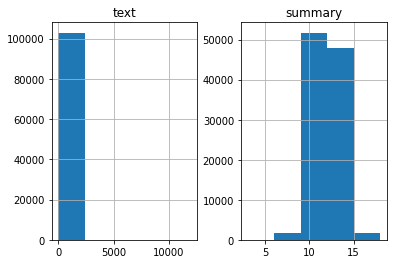

In [20]:
import matplotlib.pyplot as plt

text_count = []
summary_count = []

for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
    
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 5)
plt.show()

from the graphs, you can determine the range where the maximum number of words fall into. For summary, you can assign the range to be 0-15
To find the range of text which we arent able to clearly decipher from the graph, consider a random range and find the percentage of words falling into that range

In [21]:
#check how much % of text have 0-100 words

cnt = 0
for i in pre['cleaned_text']:
  if len(i.split()) <= 100:
    cnt = cnt + 1
print(cnt/len(pre['cleaned_text']))

0.9578389933440218


about 95.8% of the text pieces fall into the 0-100 category. now initialize the maximum permissible lengths of both text and summary

In [22]:
#model to summarize the text between 0-15 words for summary and 0-100 words for text
max_text_len = 100
max_summary_len = 15

**Selecting Plausible Texts and Summaries**

select texts and summaries which are below the maximum lengths as defined above  

In [23]:
#select the summaries and text which fall below max length

import numpy as np

cleaned_text = np.array(pre['cleaned_text'])
cleaned_summary = np.array(pre['cleaned_summary'])

short_text = []
short_summary = []
for i in range (len(cleaned_text)):
  if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
    short_text.append(cleaned_text[i])
    short_summary.append(cleaned_summary[i])

post_pre = pd.DataFrame({'text':short_text, 'summary':short_summary})

post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_ upgrad learner switches to career in m...
1,kunal shah credit card bill payment platform c...,_START_ delhi techie wins free food from swigg...


now add start of the sequence (sostok) and end of the sequence (eostok) to denote start and end of the summaries, respectively. this shall be useful to trigger the star of summarization during the inferencing phase

In [24]:

# Add sostok and eostok

post_pre['summary'] = post_pre['summary'].apply(lambda x: 'sostok ' + x \
        + ' eostok')

post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,sostok _START_ upgrad learner switches to care...
1,kunal shah credit card bill payment platform c...,sostok _START_ delhi techie wins free food fro...


**Tokenizing the text**

In [25]:
#split the data into train and test data chunks
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(post_pre["text"]),
    np.array(post_pre["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [26]:
#prepare and tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer on training data
x_tokenizer = Tokenizer(char_level=True)
x_tokenizer.fit_on_texts(list(x_tr))

find the percentage of occurence of rare words(say, occuring less than 5 times) in the text

In [27]:
thresh = 5
cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
  tot_cnt = tot_cnt + 1
  if value < thresh:
    cnt = cnt+1
print("% of rare words in vocabulary: ", (cnt/tot_cnt)*100)

% of rare words in vocabulary:  15.315315315315313


tokenize the text again by considering the total number of words minus the rare occurrences. convert text to numbers and pad them all to the same length

In [28]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt, char_level=True) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 95


do the same for the summaries as well

In [29]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 5

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 62.55667945587723
Size of vocabulary in Y = 12883


**Removing empty texts and summaries**

In [30]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

repeat the same for the validation data as well

In [31]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

**Creating the Model**

In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

Next, define the Encoder and Decoder networks.


Encoder

The input length that the encoder accepts is equal to the maximum text length which you’ve already estimated in Step 3. This is then given to an Embedding Layer of dimension (total number of words captured in the text vocabulary) x (number of nodes in an embedding layer)  (calculated in Step 5; the x_voc variable). This is followed by three LSTM networks wherein each layer returns the LSTM output, as well as the hidden and cell states observed at the previous time steps.




Decoder

In the decoder, an embedding layer is defined followed by an LSTM network. The initial state of the LSTM network is the last hidden and cell states taken from the encoder. The output of the LSTM is given to a Dense layer wrapped in a TimeDistributed layer with an attached softmax activation function.

Altogether, the model accepts encoder (text) and decoder (summary) as input and it outputs the summary. The prediction happens through predicting the upcoming word of the summary from the previous word of the summary (see the below figure).


In [33]:
latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 200)     19000       ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 100, 300),   601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

**Training the Model**

In [34]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

Next, use the model.fit() method to fit the training data where you can define the batch size to be 128. Send the text and summary (excluding the last word in summary) as the input, and a reshaped summary tensor comprising every word (starting from the second word) as the output (which explains the infusion of intelligence into the model to predict a word, given the previous word). Besides, to enable validation during the training phase, send the validation data as well.

In [43]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=3,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[: , 1:]),)

Epoch 1/3
692/692 [==============================] - 1390s 2s/step - loss: 4.4463 - val_loss: 4.3584
Epoch 2/3
692/692 [==============================] - 1396s 2s/step - loss: 4.3423 - val_loss: 4.2840
Epoch 3/3
692/692 [==============================] - 1397s 2s/step - loss: 4.2721 - val_loss: 4.2287


Next, plot the training and validation loss metrics observed during the training phase.

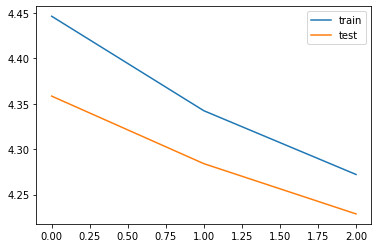

In [44]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Generating predictions**

Now that we've trained the model, to generate summaries from the given pieces of text, first reverse map the indices to the words (which has been previously generated using texts_to_sequences in Step 5). Also, map the words to indices from the summaries tokenizer which is to be used to detect the start and end of the sequences.

In [45]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

Now define the encoder and decoder inference models to start making the predictions. Use tensorflow.keras.Model() object to create your inference models.

An encoder inference model accepts text and returns the output generated from the three LSTMs, and hidden and cell states. A decoder inference model accepts the start of the sequence identifier (sostok) and predicts the upcoming word, eventually leading to predicting the whole summary.

Add the following code to define the inference models' architecture.

In [46]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

Now define a function decode_sequence() which accepts the input text and outputs the predicted summary. Start with sostok and continue generating words until eostok is encountered or the maximum length of the summary is reached. Predict the upcoming word from a given word by choosing the word which has the maximum probability attached and update the internal state of the decoder accordingly.

In [47]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

Define two functions - seq2summary() and seq2text() which convert numeric-representation to string-representation of summary and text respectively.

In [48]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

Finally, generate the predictions by sending in the text.

In [49]:
for i in range(0, 19):
    print('Review:', seq2text(x_tr[i]))
    print('Original summary:', seq2summary(y_tr[i]))
    print('Predicted summary:', decode_sequence(x_tr[i].reshape(1,
           max_text_len)))
    print('\n')

Review: s o n   c h i r a g   a s h a   i s   p a s w a n   d a u g h t e r   f r o m   h i s   f i r s t   w i f e   w h i l e   c h i r a g   i s   h i s   s o n   f r o m   h i s   s e c o n d   w i f e . 
Original summary: start will contest against father ram vilas from daughter end 
Predicted summary:  start us man jailed for killing woman who killed in delhi end


Review: a r t y   f i a n n a   f ã  â ¡ i l   t h e   p o l i t i c a l   c r i s i s   b e g a n   o v e r   f i t z g e r a l d   r o l e   i n   p o l i c e   w h i s t l e b l o w e r   s c a n d a l . 
Original summary: start irish deputy prime minister resigns to avoid govt collapse end 
Predicted summary:  start us man jailed for killing woman who killed in delhi end


Review:   b u t t l e r   i s   a l s o   o n l y   t h e   s e c o n d   b a t s m a n   a f t e r   s h a n e   w a t s o n   t o   h i t   t w o   s u c c e s s i v e   9 0 +   s c o r e s   i n   i p l . 
Original summary: start buttler equa